In [2]:
# Import libs
import pandas as pd
import time
import selenium 
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import matplotlib.pyplot as plt
import os
import logging

In [3]:
## Setup chrome options
chrome_options = Options()
chrome_options.add_argument("--headless") # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")

# Silent download of drivers
logging.getLogger('WDM').setLevel(logging.NOTSET)
os.environ['WDM_LOG'] = 'False'

# Create service
webdriver_service = Service(ChromeDriverManager().install())

# Create driver
driver = webdriver.Chrome(service = webdriver_service, options = chrome_options)

# Go to the characters in books page
page_url = "https://witcher.fandom.com/wiki/Category:Characters_in_the_stories"
driver.get(page_url)

# # Click on Accept cookies
# time.sleep(3)
# driver.find_element(By.XPATH, '//div[text()="ACCEPT"]').click()

# Find books
book_categories = driver.find_elements(by=By.CLASS_NAME, value='category-page__member-link')

books = []
for category in book_categories:
    book_url = category.get_attribute('href')
    book_name = category.text
    books.append({'book_name': book_name, "url": book_url})

[WDM] - Downloading: 100%|██████████| 8.06M/8.06M [00:00<00:00, 16.9MB/s]


In [4]:
books
character_list = []

for book in books:
    # go to book page
    driver.get(book['url'])
    
    character_elems = driver.find_elements(by=By.CLASS_NAME, value = 'category-page__member-link')
    
    for elem in character_elems:
        character_list.append({'book': book['book_name'],'character': elem.text})


In [5]:
df = pd.DataFrame(character_list)
df.to_csv('df.csv', index=False)
df

,book,character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne
3,Category:Baptism of Fire characters,Aevenien
4,Category:Baptism of Fire characters,Aglaïs
...,...,...
1270,Category:Time of Contempt characters,Yanna of Murivel
1271,Category:Time of Contempt characters,Yarpen Zigrin
1272,Category:Time of Contempt characters,Yennefer of Vengerberg
1273,Category:Time of Contempt characters,Yiolenta Suarez


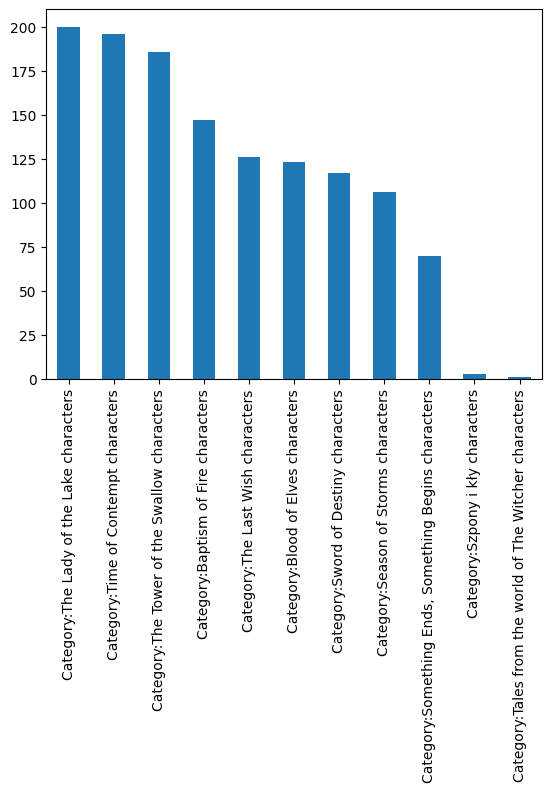

In [6]:
character_df = pd.DataFrame(character_list)

character_df['book'].value_counts().plot(kind="bar")
plt.show()

In [7]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt


In [8]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
all_books

[<DirEntry 'I - Blood of Elves.txt'>,
 <DirEntry 'B - The Sword of Destiny.txt'>,
 <DirEntry 'II - Times of Contempt.txt'>,
 <DirEntry 'E - something ends something begins.txt'>,
 <DirEntry 'IV - The Tower of the Swallow.txt'>,
 <DirEntry 'C - The Last Wish.txt'>,
 <DirEntry 'V - The Lady of the Lake.txt'>,
 <DirEntry 'III - Baptism of Fire.txt'>]

In [29]:
# Select the book file in the list and read its contents
book = [b for b in all_books if 'I - Blood of Elves.txt' in b.name][0]
with open(book, 'r') as f:
    book_text = f.read()

# Pass the book text to the spaCy model to extract named entities
book_doc = NER(book_text)

In [51]:
# Visualize identified entities
displacy.render(book_doc[4000:8000], style="ent", jupyter=True)

## Load Character Names

In [31]:
# Read charactersm
character_df = pd.read_csv("df.csv")
# Remove brackets and text within brackets
import re 
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])
pd.set_option('display.max_rows', None)
character_df.head()

,book,character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs


## Get named entity list per sentence

In [32]:

sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)
sent_entity_df.head()

,sentence,entities
0,"(﻿Verily, I, say, unto, you, ,, the, era, of, ...",[wolf]
1,"(The, Time, \n, of, the, White, Chill, and, th...","[Time, the White Chill, the White Light, the T..."
2,"(The, world, will, die, amidst, frost, and, be...",[]
3,"(It, will, be, reborn, of, the, Elder, Blood, ...","[the Elder Blood, Hen Ichaer]"
4,"(A, seed, which, \n, will, not, sprout, but, w...",[]


In [33]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head()

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, earth, Aen Seidhe, the Blood of Elves,...",[Aevenien]
14,"(Ciri, felt, the, knight, who, carried, her, b...",[Ciri],[Ciri]
18,"(Ciri, caught, a, glimpse, of, the, skirmish, ...",[Ciri],[Ciri]
64,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
67,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]


## Create relationships

In [34]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})
relationship_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationship_df.head()

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Geralt of Rivia,Geralt
3,Ciri,Geralt of Rivia
4,Ciri,Geralt of Rivia


In [35]:
# Take only first name of characters
sent_entity_df_filtered.loc[:, 'character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])


/var/folders/z8/5j47p9y55kv1_ngl2nr5fkhc0000gn/T/ipykernel_31429/516163864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered.loc[:, 'character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])


In [36]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, earth, Aen Seidhe, the Blood of Elves,...",[Aevenien]
14,"(Ciri, felt, the, knight, who, carried, her, b...",[Ciri],[Ciri]
18,"(Ciri, caught, a, glimpse, of, the, skirmish, ...",[Ciri],[Ciri]
64,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
67,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]
...,...,...,...
10635,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]
10639,"(Nenneke, did, not, look, at, \n, them, ., \n)",[Nenneke],[Nenneke]
10642,"(It, might, turn, out, to, be, true, ,, what, ...","[Ithlinne, Aevenien]","[Ithlinne, Aevenien]"
10645,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]


## Create relationships

In [37]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})
relationship_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationship_df.head(20)

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Ciri,Geralt
3,Ciri,Geralt
4,Geralt,Yennefer
5,Geralt,Yennefer
6,Yennefer,Cirilla
7,Geralt,Yennefer
8,Yennefer,Cirilla
9,Geralt,Yennefer


In [38]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head(20)

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Ciri,Geralt
3,Ciri,Geralt
4,Geralt,Yennefer
5,Geralt,Yennefer
6,Cirilla,Yennefer
7,Geralt,Yennefer
8,Cirilla,Yennefer
9,Geralt,Yennefer


In [39]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df.head(10)

,source,target,value
0,Ciri,Geralt,297
1,Geralt,Yennefer,128
2,Cirilla,Yennefer,5
3,Cirilla,Dandelion,4
4,Donimir,Sheldon,5
5,Geralt,Vera,7
6,Dandelion,Geralt,47
7,Geralt,Pavetta,2
8,Ciri,Pavetta,17
9,Ciri,Cirilla,17


## Graph analysis and visualization

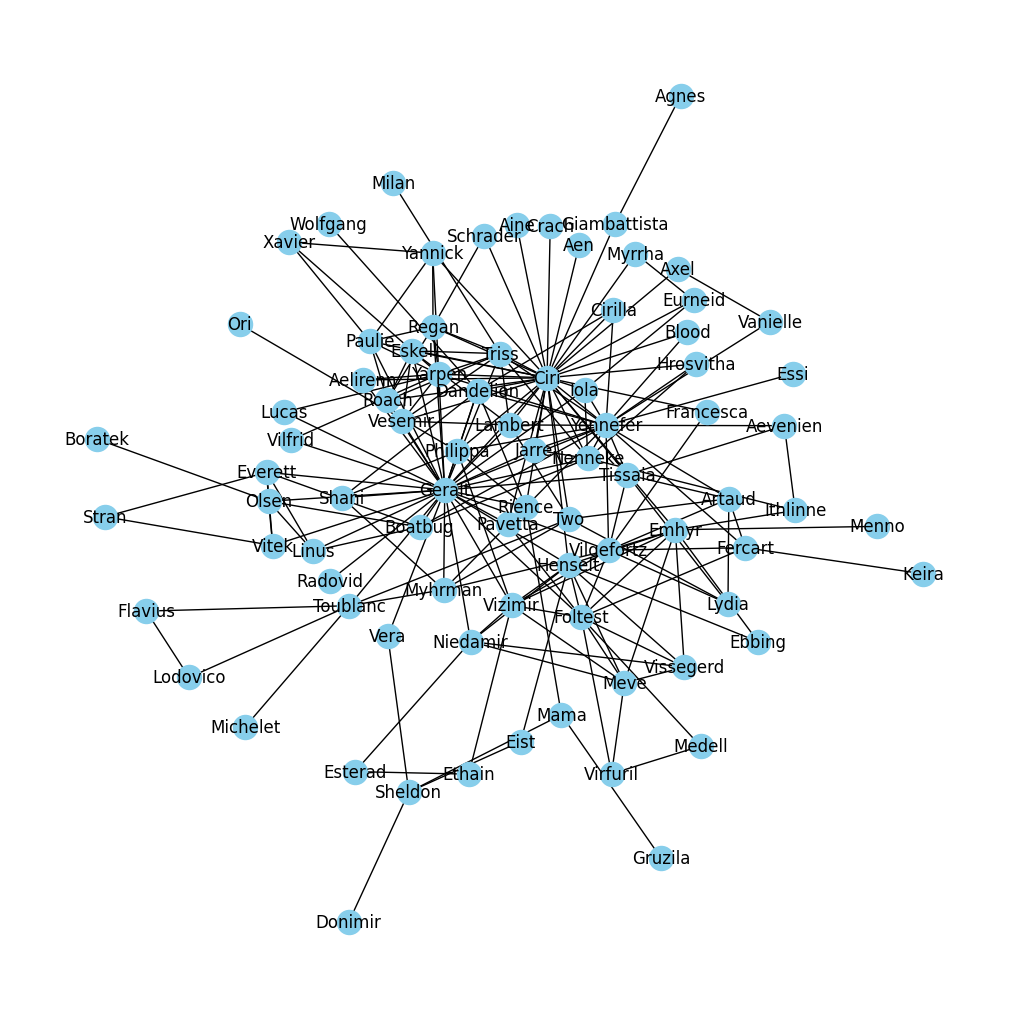

In [40]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())
#Graph visualization - Networkx
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


In [41]:
from pyvis.network import Network
net = Network(notebook = True, bgcolor='#222222', font_color='white',cdn_resources='remote')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")


witcher.html


In [42]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Ciri': 0.4268292682926829,
 'Geralt': 0.43902439024390244,
 'Yennefer': 0.2682926829268293,
 'Cirilla': 0.03658536585365854,
 'Dandelion': 0.0975609756097561,
 'Donimir': 0.012195121951219513,
 'Sheldon': 0.04878048780487805,
 'Vera': 0.024390243902439025,
 'Pavetta': 0.03658536585365854,
 'Eist': 0.024390243902439025,
 'Mama': 0.03658536585365854,
 'Rience': 0.08536585365853659,
 'Gruzila': 0.012195121951219513,
 'Niedamir': 0.07317073170731708,
 'Roach': 0.07317073170731708,
 'Eskel': 0.07317073170731708,
 'Vesemir': 0.07317073170731708,
 'Lambert': 0.08536585365853659,
 'Triss': 0.13414634146341464,
 'Two': 0.07317073170731708,
 'Nenneke': 0.10975609756097561,
 'Axel': 0.024390243902439025,
 'Vanielle': 0.024390243902439025,
 'Fercart': 0.06097560975609756,
 'Foltest': 0.13414634146341464,
 'Keira': 0.012195121951219513,
 'Artaud': 0.07317073170731708,
 'Vilgefortz': 0.13414634146341464,
 'Milan': 0.012195121951219513,
 'Yarpen': 0.14634146341463417,
 'Xavier': 0.03658536585365854

<Axes: >

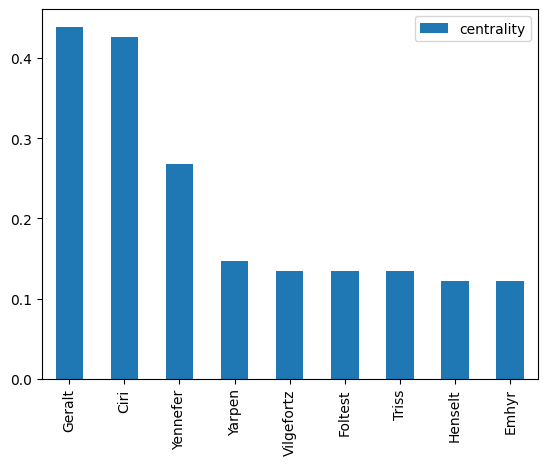

In [43]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

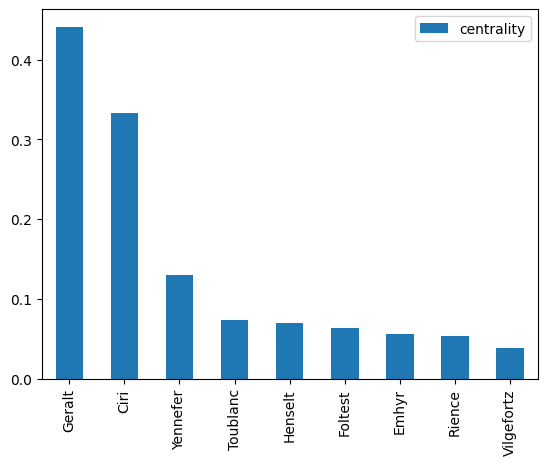

In [44]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

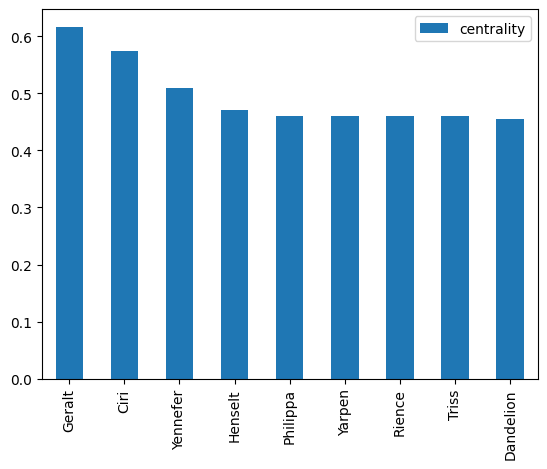

In [45]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [46]:
import community
dir(community)

['__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'best_partition',
 'community_louvain',
 'community_status',
 'generate_dendrogram',
 'induced_graph',
 'load_binary',
 'modularity',
 'partition_at_level']

In [47]:
from community import community_louvain

In [48]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
#Community detection
import community as community_louvain
communities = community_louvain.best_partition(G)
communities
nx.set_node_attributes(G, communities, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")



witcher_communities.html
